## Import Packages

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Model, load_model
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization, Input
from tensorflow.keras.layers import ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Add
from tensorflow.keras.layers import GlobalMaxPooling2D, Reshape
from tensorflow.keras.layers import Activation, Conv2D, Average
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Helper Functions

In [2]:
def plot_confusion_matrix(cm, classes):

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Read true labels + Basic EDA

In [3]:
train_df = pd.read_csv("../input/hackereath-holiday-season-deep-learning-contest/dataset/train.csv")
train_df.head()

,Image,Class
0,image3476.jpg,Miscellaneous
1,image5198.jpg,Candle
2,image4183.jpg,Snowman
3,image1806.jpg,Miscellaneous
4,image7831.jpg,Miscellaneous


In [4]:
class_map = {
    'Airplane': 0,
    'Candle': 1,
    'Christmas_Tree': 2,
    'Jacket': 3,
    'Miscellaneous': 4,
    'Snowman': 5
}

In [5]:
train_df['Class_enc'] = train_df['Class'].map(class_map)
train_df['Class_enc'] = train_df['Class_enc'].astype('str')
train_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,535
1,Candle,1,593
2,Christmas_Tree,2,1539
3,Jacket,3,640
4,Miscellaneous,4,2801
5,Snowman,5,361


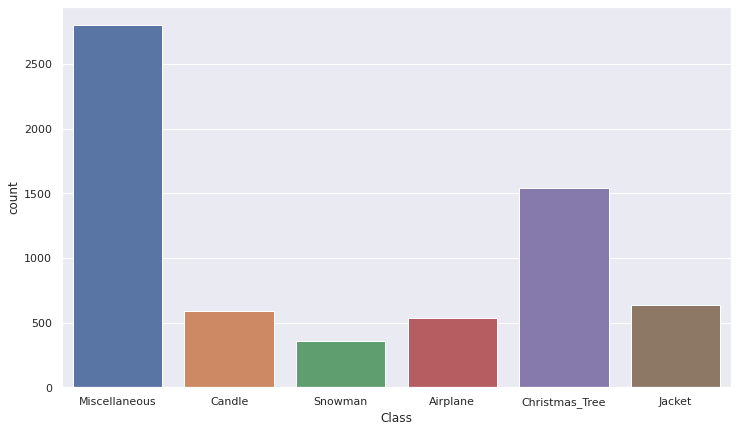

In [6]:
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="Class", data=train_df)

In [7]:
test_dir = "../input/hackereath-holiday-season-deep-learning-contest/dataset/test"
test_files = []

for file in tqdm(os.listdir(test_dir)):
    test_files.append(file)

test_df = pd.DataFrame(test_files, columns=['Image'])
test_df['Class'] = '0'
test_df.head()

100%|██████████| 3489/3489 [00:00<00:00, 465826.09it/s]


,Image,Class
0,image7761.jpg,0
1,image3202.jpg,0
2,image688.jpg,0
3,image233.jpg,0
4,image4332.jpg,0


## Calculate class-weights

In [8]:
temp_df = train_df.groupby(['Class_enc']).size().reset_index().rename(columns={0:'count'})
total_count = np.sum(temp_df['count'].values)
temp_df['class%'] = (temp_df['count'] / total_count) * 100
lowest_pct = min(temp_df['class%'])
temp_df['class_weight'] = lowest_pct / temp_df['class%']
class_weight = temp_df[['Class_enc', 'class_weight']].to_dict()['class_weight']
class_weight

{0: 0.6747663551401869,
 1: 0.6087689713322091,
 2: 0.23456790123456786,
 3: 0.5640625,
 4: 0.12888254194930382,
 5: 1.0}

## Split training data into train/validation datasets

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
for train_index, validation_index in sss.split(train_df['Image'], train_df['Class_enc']):
    train_df, validation_df = train_df.iloc[train_index], train_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

train_df shape: (5498, 3)
validation_df shape: (971, 3)


In [10]:
train_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,455
1,Candle,1,504
2,Christmas_Tree,2,1308
3,Jacket,3,544
4,Miscellaneous,4,2380
5,Snowman,5,307


In [11]:
validation_df.groupby(['Class','Class_enc']).size().reset_index().rename(columns={0:'Count'})

,Class,Class_enc,Count
0,Airplane,0,80
1,Candle,1,89
2,Christmas_Tree,2,231
3,Jacket,3,96
4,Miscellaneous,4,421
5,Snowman,5,54


## Model Hyperparameters

In [12]:
dataset_dir = "../input/hackereath-holiday-season-deep-learning-contest/dataset/"
mini_batch_size = 64
steps_per_epoch = int(np.ceil(train_df.shape[0] / float(mini_batch_size)))
validation_steps = int(np.ceil(validation_df.shape[0] / float(mini_batch_size)))
test_steps = int(np.ceil(test_df.shape[0] / float(mini_batch_size)))
image_dim = (320, 320, 3)

## Configure image generators

In [13]:
def train_generator():

    while True:
        train_datagen = ImageDataGenerator(rotation_range = 30,
                                           zoom_range = 0.2,
                                           horizontal_flip = True,
                                           fill_mode = 'nearest',
                                           height_shift_range = 0.1,
                                           width_shift_range = 0.1)

        batches = train_datagen.flow_from_dataframe(train_df,
                                                    directory = os.path.join(dataset_dir,"train"),
                                                    x_col = "Image", 
                                                    y_col = "Class_enc",
                                                    target_size = (image_dim[0], image_dim[1]),
                                                    batch_size = mini_batch_size,
                                                    class_mode = "categorical",
                                                    interpolation="bicubic")

        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], batch[0], batch[0]], batch[1]

            idx0 = idx1
            if idx1 >= train_df.shape[0]:
                break

In [14]:
def validation_generator():

    while True:
        validation_datagen = ImageDataGenerator()

        batches = validation_datagen.flow_from_dataframe(validation_df,
                                                         directory = os.path.join(dataset_dir,"train"),
                                                         x_col = "Image",
                                                         y_col = "Class_enc",
                                                         shuffle=False,
                                                         target_size = (image_dim[0], image_dim[1]),
                                                         batch_size = mini_batch_size,
                                                         class_mode = "categorical",
                                                         interpolation="bicubic")

        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], batch[0], batch[0]], batch[1]

            idx0 = idx1
            if idx1 >= validation_df.shape[0]:
                break

In [15]:
def test_generator():

    while True:
        test_datagen = ImageDataGenerator()

        batches = test_datagen.flow_from_dataframe(test_df,
                                                   directory = os.path.join(dataset_dir,"test"),
                                                   x_col = "Image",
                                                   y_col = "Class",
                                                   shuffle=False,
                                                   target_size = (image_dim[0], image_dim[1]),
                                                   batch_size = mini_batch_size,
                                                   class_mode = "categorical",
                                                   interpolation="bicubic")

        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], batch[0], batch[0]], batch[1]

            idx0 = idx1
            if idx1 >= test_df.shape[0]:
                break

## Build and validate the model

In [16]:
def head(x1, x2, x3):
    
    x = Concatenate()([x1, x2, x3])
    
    x = Dense(units=2048, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=512, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=512, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=128, kernel_regularizer=l2(0.0001), 
              kernel_initializer='he_uniform')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.5)(x)
    
    x = Dense(units=6, activation='softmax', 
              kernel_initializer='he_uniform')(x)

    return x

In [17]:
# Load the pre-trained models
base_model1 = load_model('../input/holiday-season-enetb4-mav34/hackerearth_holiday_season_model.h5')
base_model2 = load_model('../input/holiday-season-enetb5-mav4/hackerearth_holiday_season_model.h5')
base_model3 = load_model('../input/holiday-season-enetb6-mav4/hackerearth_holiday_season_model.h5')

# Freeze weights for base models
base_model1.trainable = False
for layer in base_model1.layers[-17:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

base_model2.trainable = False
for layer in base_model2.layers[-17:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

base_model3.trainable = False
for layer in base_model3.layers[-17:]:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = True

# Update layer names for base models
for layer in tqdm(base_model1.layers):
    layer._name = 'm1_' + layer.name

for layer in tqdm(base_model2.layers):
    layer._name = 'm2_' + layer.name

for layer in tqdm(base_model3.layers):
    layer._name = 'm3_' + layer.name

# Build the model
model = Model(inputs=[base_model1.input, base_model2.input, base_model3.input], 
              outputs=head(base_model1.get_layer('m1_activation_11').output, 
                           base_model2.get_layer('m2_activation_11').output,
                           base_model3.get_layer('m3_activation_11').output),
              name='HackerEarth_Holiday_Season_Model')

# Compile the final model
model.compile(loss='categorical_crossentropy', 
              metrics=[F1Score(num_classes=6, average='weighted'), 
                       'categorical_accuracy'],
              optimizer=Lookahead(AdamW(lr=1e-4, 
                                        weight_decay=1e-5, 
                                        clipvalue=700), 
                                  sync_period=10))

# Load best weights from pre-trained model
model.load_weights('../input/holiday-season-enetb456-mav1/hackerearth_holiday_season_model.h5')

# Configure model callbacks
early = EarlyStopping(monitor="val_loss", mode="min", patience=5, 
                      restore_best_weights=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, 
                              min_lr=1e-6, patience=3, 
                              verbose=1, mode='min')

chk_point = ModelCheckpoint('hackerearth_holiday_season_model.h5', 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')

100%|██████████| 722/722 [00:00<00:00, 28667.73it/s]


In [18]:
history = model.fit(
    train_generator(), 
    steps_per_epoch=steps_per_epoch,
    class_weight=class_weight, 
    epochs=25, 
    verbose=1, 
    callbacks=[reduce_lr, early, chk_point], 
    validation_data=validation_generator(),
    validation_steps=validation_steps
)

Found 5498 validated image filenames belonging to 6 classes.
Epoch 1/25
86/86 [==============================] - ETA: 0s - loss: 0.1945 - f1_score: 0.9811 - categorical_accuracy: 0.9811Found 971 validated image filenames belonging to 6 classes.
Found 971 validated image filenames belonging to 6 classes.

Epoch 00001: val_loss improved from inf to 0.44531, saving model to hackerearth_holiday_season_model.h5
86/86 [==============================] - 267s 3s/step - loss: 0.1945 - f1_score: 0.9811 - categorical_accuracy: 0.9811 - val_loss: 0.4453 - val_f1_score: 0.9319 - val_categorical_accuracy: 0.9320
Epoch 2/25
86/86 [==============================] - ETA: 0s - loss: 0.1785 - f1_score: 0.9789 - categorical_accuracy: 0.9789Found 5498 validated image filenames belonging to 6 classes.
Found 971 validated image filenames belonging to 6 classes.

Epoch 00002: val_loss improved from 0.44531 to 0.41761, saving model to hackerearth_holiday_season_model.h5
86/86 [==============================] -

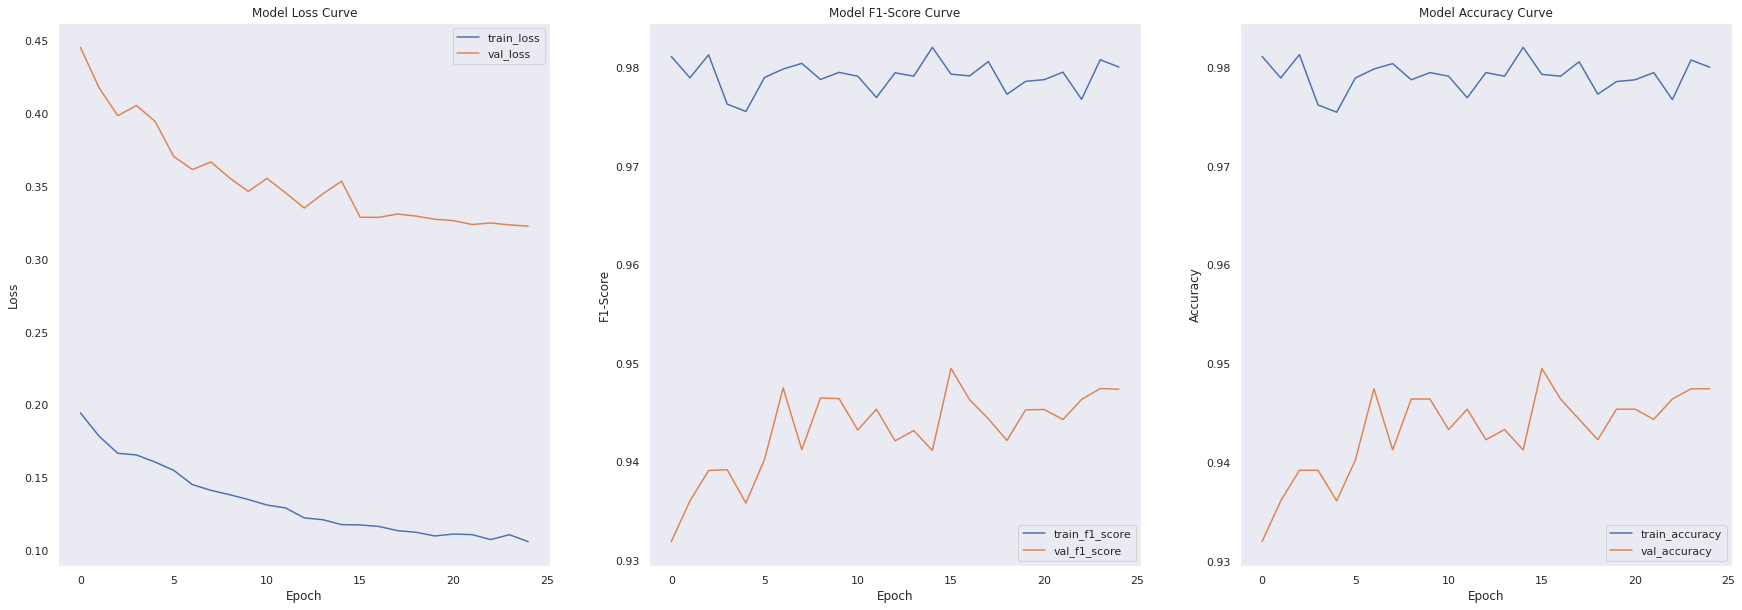

In [19]:
_, ax = plt.subplots(1, 3, figsize=(30, 10))

ax[0].plot(history.history['loss'], label='train_loss')
ax[0].plot(history.history['val_loss'], label='val_loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title("Model Loss Curve")
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['f1_score'], label='train_f1_score')
ax[1].plot(history.history['val_f1_score'], label='val_f1_score')
ax[1].set_ylabel('F1-Score')
ax[1].set_xlabel('Epoch')
ax[1].set_title("Model F1-Score Curve")
ax[1].legend()
ax[1].grid()

ax[2].plot(history.history['categorical_accuracy'], label='train_accuracy')
ax[2].plot(history.history['val_categorical_accuracy'], label='val_accuracy')
ax[2].set_ylabel('Accuracy')
ax[2].set_xlabel('Epoch')
ax[2].set_title("Model Accuracy Curve")
ax[2].legend()
ax[2].grid()

## Check classification report

In [20]:
model = load_model('./hackerearth_holiday_season_model.h5')

ValueError: The name "tf_op_layer_er_AddV2" is used 3 times in the model. All layer names should be unique.

In [21]:
y_true = validation_df['Class_enc'].values
y_pred = model.predict(validation_generator(), steps=validation_steps, verbose=1)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true.astype(int), y_pred))

Found 971 validated image filenames belonging to 6 classes.
16/16 [==============================] - 21s 1s/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        80
           1       0.94      0.87      0.90        89
           2       0.95      0.94      0.94       231
           3       0.97      0.97      0.97        96
           4       0.94      0.97      0.96       421
           5       0.88      0.94      0.91        54

    accuracy                           0.95       971
   macro avg       0.95      0.94      0.94       971
weighted avg       0.95      0.95      0.95       971



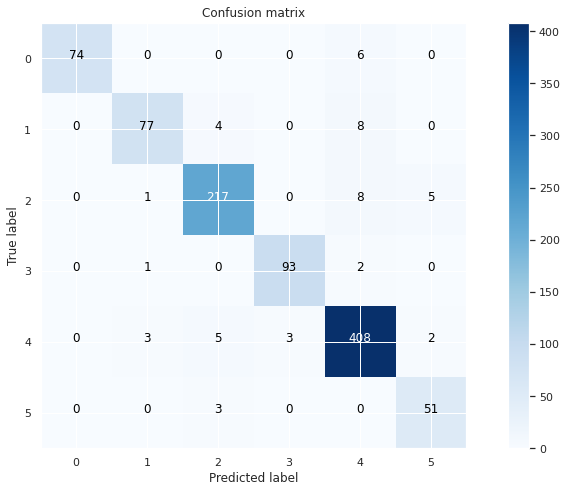

In [22]:
cnf_matrix = confusion_matrix(y_true.astype(int), y_pred, labels=[0, 1, 2, 3, 4, 5])
np.set_printoptions(precision=2)
plt.figure(figsize=(12,7))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4, 5])

## Create submission file

In [23]:
rev_class_map = {
    0: 'Airplane',
    1: 'Candle',
    2: 'Christmas_Tree',
    3: 'Jacket',
    4: 'Miscellaneous',
    5: 'Snowman'
}

In [24]:
y_pred_final = model.predict(test_generator(), steps=test_steps, verbose=1)
y_pred_final = np.argmax(y_pred_final, axis=1)
print(y_pred_final.shape)

Found 3489 validated image filenames belonging to 1 classes.
55/55 [==============================] - 79s 1s/step
(3489,)


In [25]:
test_df['Class'] = y_pred_final
test_df['Class'] = test_df['Class'].map(rev_class_map)
test_df.head()

,Image,Class
0,image7761.jpg,Miscellaneous
1,image3202.jpg,Miscellaneous
2,image688.jpg,Snowman
3,image233.jpg,Candle
4,image4332.jpg,Christmas_Tree


In [26]:
test_df.to_csv("/kaggle/working/submission.csv", index=False)